### Load Label Indexes
This chunk loads a file that contains the labels we want to load from the datasets as well as their indicies.

In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib
import os
import seaborn as sn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydot
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import (RandomOverSampler, SMOTE, ADASYN)
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import Dropout
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report



%matplotlib inline
class_names = ["Normal", "Corrupt", "Delay", "Duplicate", "Loss"]

seed = 0

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, fig_size=(12,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Using TensorFlow backend.


In [2]:
infile = open("tstat_labels_indexes.txt" ,'r')
data_field_list = []
for line in infile.readlines():
    if ":" in line:
        data_field = str(re.search('%s(.*)%s' % ("\"", "\""), line).group(1))
        index = int(re.search('%s(.*)%s' % (":", ","), line).group(1))
        data_field_list.append((data_field, index))

index_to_key_dict = {}
key_to_index_dict = {}
data_field_labels = []
for data_field, index in data_field_list:
    key_to_index_dict[data_field] = index
    index_to_key_dict[index] = data_field
    data_field_labels.append(data_field)
    

### Read in a dataset file

In [3]:
def read_in_file(file_name):
    infile = open(file_name, 'r')
    header = infile.readline().split(' ')
    entries = []
    labels = None
    for i, line in enumerate(infile.readlines()):
        row = get_data_row(line)
        row = clean_data_row(row)
        if row != []:
            entries.append(row)
    entries = np.array(entries)
    return entries

### Get data row
Called by the read in file function. Loads a single line from the dataset files. Super inefficient, but only loads labels which are in the data field list. 

In [4]:
def get_data_row(line):
    global index_to_key_dict
    line = line.split(' ')
    row = []
    labels = []
    c_pkt_cnt = 0
    s_pkt_cnt = 0
    c_bytes_cnt = 0
    s_bytes_cnt = 0
    for data_field, index in data_field_list:
        #print("df:", data_field,"ix:",index)
        #print(line)
        
        
        if data_field == "client_pkt_cnt":
            try:
                c_pkt_cnt = line[index]
                c_pkt_cnt = max(float(c_pkt_cnt), 1)
            except:
                c_pkt_cnt = 1
            #if c_pkt_cnt < 32:
            #    return []
        elif data_field == "serv_pkt_cnt":
            try:
                s_pkt_cnt = line[index]
                s_pkt_cnt = max(float(s_pkt_cnt), 1)
            except:
                s_pkt_cnt = 1
        elif data_field == "client_bytes_cnt":
            try:
                c_bytes_cnt = line[index]
                c_bytes_cnt = max(float(c_bytes_cnt), 1)
            except:
                c_bytes_cnt = 1
        elif data_field == "serv_bytes_cnt":
            try:
                s_bytes_cnt = line[index]
                s_bytes_cnt = max(float(s_bytes_cnt), 1)
            except:
                s_bytes_cnt = 1
                
    for data_field, index in data_field_list:
        try:
            val = line[index]
            val = float(val)
        except:
            val = 0
        row.append(val)    
    return row

In [5]:
#def metricName(index):

### Clean data row
Not implemented

In [6]:
def clean_data_row(in_row):
    global index_to_key_dict, key_to_index_dict
    return in_row

### Get dataset
Loads all files from a directory

In [7]:
def get_dataset(path):
    print(path)
    out_data = []
    for sub_dir in os.listdir(path):
        temp_path = os.path.join(path, sub_dir)
        temp_path = os.path.join(temp_path, "log_tcp_complete")
        if os.path.isfile(temp_path): 
            temp_data = read_in_file(temp_path)
            #print len(temp_data), len(out_data)
            if len(temp_data) == 0:
                continue
            if out_data == []:
                out_data = temp_data
            else:
                out_data = np.concatenate((out_data, temp_data))
    return out_data

### Load HPC datasets
Load all datasets
Create numerical lables for each class, and a different set of labels for each subclass.

In [8]:


normal = get_dataset("./hpc/normal")
corr_01 = get_dataset("./hpc/corrupt_0.1perc")
corr_05 = get_dataset("./hpc/corrupt_0.5perc")
corr_10 = get_dataset("./hpc/corrupt_1.0perc")
delay_1_1 = get_dataset("./hpc/delay_1_var_1")
delay_5_2 = get_dataset("./hpc/delay_5_var_2")
delay_10_5 = get_dataset("./hpc/delay_10_var_5")
delay_25_20 = get_dataset("./hpc/delay_25_var_20")
drop_01 = get_dataset("./hpc/loss_5perc")
drop_001 = get_dataset("./hpc/loss_10perc")
drop_0005 = get_dataset("./hpc/loss_15perc")

#drop_01 = get_dataset("./hpc/drop_01_perc")
#drop_001 = get_dataset("./hpc/drop_001_perc")
#drop_0005 = get_dataset("./hpc/drop_0005_perc")

dup_1 = get_dataset("./hpc/dup_10perc")
dup_2 = get_dataset("./hpc/dup_20perc")

hpc_normal = np.nan_to_num(normal)
hpc_corr_01 = np.nan_to_num(corr_01)
hpc_corr_05 =  np.nan_to_num(corr_05)
hpc_corr_10 = np.nan_to_num(corr_10)
hpc_delay_1_1 = np.nan_to_num(delay_1_1)
hpc_delay_5_2 = np.nan_to_num(delay_5_2)
hpc_delay_10_5 = np.nan_to_num(delay_10_5)
hpc_delay_25_20 = np.nan_to_num(delay_25_20)
hpc_drop_01 = np.nan_to_num(drop_01)
hpc_drop_001 = np.nan_to_num(drop_001)
hpc_drop_0005 = np.nan_to_num(drop_0005)
hpc_dup_1 = np.nan_to_num(dup_1)
hpc_dup_2 = np.nan_to_num(dup_2)


./hpc/normal
./hpc/corrupt_0.1perc


/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


./hpc/corrupt_0.5perc
./hpc/corrupt_1.0perc
./hpc/delay_1_var_1
./hpc/delay_5_var_2
./hpc/delay_10_var_5
./hpc/delay_25_var_20
./hpc/loss_5perc
./hpc/loss_10perc
./hpc/loss_15perc
./hpc/dup_10perc
./hpc/dup_20perc


In [9]:
normal = get_dataset("./dtn/FINAL_DATA/normal")
normal_2 = get_dataset("./dtn/DTN_LONG_DATA/normal")
corr_01 = get_dataset("./dtn/FINAL_DATA/corrupt_0.1perc")
corr_05 = get_dataset("./dtn/FINAL_DATA/corrupt_0.5perc")
corr_10 = get_dataset("./dtn/FINAL_DATA/corrupt_1.0perc")
delay_1_1 = get_dataset("./dtn/FINAL_DATA/delay_1_var_1")
delay_5_2 = get_dataset("./dtn/FINAL_DATA/delay_5_var_2")
delay_10_5 = get_dataset("./dtn/FINAL_DATA/delay_10_var_5")
delay_25_20 = get_dataset("./dtn/FINAL_DATA/delay_25_var_20")
drop_01 = get_dataset("./dtn/FINAL_DATA/loss_1perc")
drop_001 = get_dataset("./dtn/FINAL_DATA/loss_5perc")

#drop_001_2 = get_dataset("./dtn/DTN_LONG_DATA/tenth_perc")
#drop_01_2 = get_dataset("./dtn/DTN_LONG_DATA/one_perc")

drop_0005 = get_dataset("./dtn/FINAL_DATA/loss_10perc")
drop_0005_2 = get_dataset("./dtn/FINAL_DATA/loss_15perc")
dup_01 = get_dataset("./dtn/FINAL_DATA/dup_0.1perc")
dup_1 = get_dataset("./dtn/FINAL_DATA/dup_1perc")
dup_2 = get_dataset("./dtn/FINAL_DATA/dup_2perc")

dtn_normal = np.nan_to_num(normal)
dtn_normal2 = np.nan_to_num(normal_2)
dtn_corr_01 = np.nan_to_num(corr_01)
dtn_corr_05 =  np.nan_to_num(corr_05)
dtn_corr_10 = np.nan_to_num(corr_10)
dtn_delay_1_1 = np.nan_to_num(delay_1_1)
dtn_delay_5_2 = np.nan_to_num(delay_5_2)
dtn_delay_10_5 = np.nan_to_num(delay_10_5)
dtn_delay_25_20 = np.nan_to_num(delay_25_20)
dtn_drop_01 = np.nan_to_num(drop_01)
#dtn_drop_01_2 = np.nan_to_num(drop_01_2)
dtn_drop_001 = np.nan_to_num(drop_001)
#dtn_drop_001_2 = np.nan_to_num(drop_001_2)
dtn_drop_0005 = np.nan_to_num(drop_0005)
dtn_drop_0005_2 = np.nan_to_num(drop_0005_2)
dtn_dup_01 = np.nan_to_num(dup_01)
dtn_dup_1 = np.nan_to_num(dup_1)
dtn_dup_2 = np.nan_to_num(dup_2)



./dtn/FINAL_DATA/normal
./dtn/DTN_LONG_DATA/normal


/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


./dtn/FINAL_DATA/corrupt_0.1perc
./dtn/FINAL_DATA/corrupt_0.5perc
./dtn/FINAL_DATA/corrupt_1.0perc
./dtn/FINAL_DATA/delay_1_var_1
./dtn/FINAL_DATA/delay_5_var_2
./dtn/FINAL_DATA/delay_10_var_5
./dtn/FINAL_DATA/delay_25_var_20
./dtn/FINAL_DATA/loss_1perc
./dtn/FINAL_DATA/loss_5perc
./dtn/FINAL_DATA/loss_10perc
./dtn/FINAL_DATA/loss_15perc
./dtn/FINAL_DATA/dup_0.1perc
./dtn/FINAL_DATA/dup_1perc
./dtn/FINAL_DATA/dup_2perc


In [10]:

normal = get_dataset("./emulab/normal")
corr_01 = get_dataset("./emulab/corrupt_0.1perc")
corr_5 = get_dataset("./emulab/corrupt_5perc")
corr_10 = get_dataset("./emulab/corrupt_1.0perc")
delay_1_1 = get_dataset("./emulab/delay_1_var_1")
delay_5_2 = get_dataset("./emulab/delay_5_var_2")
delay_10_5 = get_dataset("./emulab/delay_10_var_5")
delay_25_20 = get_dataset("./emulab/delay_25_var_20")
drop_1 = get_dataset("./emulab/loss_1_perc")
drop_2 = get_dataset("./emulab/loss_1perc")
drop_3 = get_dataset("./emulab/loss_5_perc")
drop_4 = get_dataset("./emulab/loss_5perc")
drop_5 = get_dataset("./emulab/loss_10perc")
drop_6 = get_dataset("./emulab/loss_10_perc")
drop_7 = get_dataset("./emulab/loss_15perc")
dup_1 = get_dataset("./emulab/dup_1perc")
dup_5 = get_dataset("./emulab/dup_5perc")
dup_7 = get_dataset("./emulab/dup_7perc")

emulab_normal = np.nan_to_num(normal)
emulab_corr_01 = np.nan_to_num(corr_01)
emulab_corr_05 =  np.nan_to_num(corr_5)
emulab_corr_10 = np.nan_to_num(corr_10)
emulab_delay_1_1 = np.nan_to_num(delay_1_1)
emulab_delay_5_2 = np.nan_to_num(delay_5_2)
emulab_delay_10_5 = np.nan_to_num(delay_10_5)
emulab_delay_25_20 = np.nan_to_num(delay_25_20)
emulab_drop_1 = np.nan_to_num(drop_1)
emulab_drop_2 = np.nan_to_num(drop_2)
emulab_drop_3 = np.nan_to_num(drop_3)
emulab_drop_4 = np.nan_to_num(drop_4)
emulab_drop_5 = np.nan_to_num(drop_5)
emulab_drop_6 = np.nan_to_num(drop_6)
emulab_drop_7 = np.nan_to_num(drop_7)
emulab_dup_1 = np.nan_to_num(dup_1)
emulab_dup_2 = np.nan_to_num(dup_2)
emulab_dup_7 = np.nan_to_num(dup_7)

./emulab/normal


/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == '':


./emulab/corrupt_0.1perc
./emulab/corrupt_5perc
./emulab/corrupt_1.0perc
./emulab/delay_1_var_1
./emulab/delay_5_var_2
./emulab/delay_10_var_5
./emulab/delay_25_var_20
./emulab/loss_1_perc
./emulab/loss_1perc
./emulab/loss_5_perc
./emulab/loss_5perc
./emulab/loss_10perc
./emulab/loss_10_perc
./emulab/loss_15perc
./emulab/dup_1perc
./emulab/dup_5perc
./emulab/dup_7perc


In [11]:

hpc_data = np.concatenate((hpc_normal, 
                           hpc_corr_01, hpc_corr_05, hpc_corr_10,
                           hpc_delay_1_1, hpc_delay_5_2,hpc_delay_10_5,hpc_delay_25_20,
                           hpc_drop_01, hpc_drop_001, hpc_drop_0005,
                           hpc_dup_1, hpc_dup_2))


emulab_data = np.concatenate((emulab_normal, 
                           emulab_corr_01, emulab_corr_05, emulab_corr_10,
                           emulab_delay_1_1, emulab_delay_5_2,emulab_delay_10_5,emulab_delay_25_20,
                           emulab_drop_1, emulab_drop_2, emulab_drop_3,emulab_drop_4,emulab_drop_5,emulab_drop_6,emulab_drop_7,
                           emulab_dup_1, emulab_dup_2,emulab_dup_7))


dtn_data = np.concatenate((dtn_normal, dtn_normal2,
                           dtn_corr_01, dtn_corr_05, dtn_corr_10,
                           dtn_delay_1_1, dtn_delay_5_2,dtn_delay_10_5,dtn_delay_25_20,
                           dtn_drop_01, dtn_drop_001, dtn_drop_0005, dtn_drop_0005_2,                          
                           dtn_dup_01,dtn_dup_1, dtn_dup_2))


all_data = np.concatenate((hpc_normal, 
                           hpc_corr_01, hpc_corr_05, hpc_corr_10,
                           hpc_delay_1_1, hpc_delay_5_2,hpc_delay_10_5,hpc_delay_25_20,
                           hpc_drop_01, hpc_drop_001, hpc_drop_0005,
                           hpc_dup_1, hpc_dup_2, 
                           dtn_normal, dtn_normal2,
                           dtn_corr_01, dtn_corr_05, dtn_corr_10,
                           dtn_delay_1_1, dtn_delay_5_2,dtn_delay_10_5,dtn_delay_25_20,
                           dtn_drop_01, dtn_drop_001, dtn_drop_0005, dtn_drop_0005_2,                          
                           dtn_dup_01,dtn_dup_1, dtn_dup_2,emulab_normal, 
                           emulab_corr_01, emulab_corr_05, emulab_corr_10,
                           emulab_delay_1_1, emulab_delay_5_2,emulab_delay_10_5,emulab_delay_25_20,
                           emulab_drop_1, emulab_drop_2, emulab_drop_3,emulab_drop_4,emulab_drop_5,emulab_drop_6,emulab_drop_7,
                           emulab_dup_1, emulab_dup_2,emulab_dup_7))


# hpc_normal = pd.DataFrame(data=hpc_normal, 
#               columns=data_field_labels)

# hpc_corr_01 = pd.DataFrame(data=hpc_corr_01, 
#               columns=data_field_labels)

# hpc_corr_05 = pd.DataFrame(data=hpc_corr_05, 
#               columns=data_field_labels)

# hpc_corr_10 = pd.DataFrame(data=hpc_corr_10, 
#               columns=data_field_labels)

# hpc_delay_1_1 = pd.DataFrame(data=hpc_delay_1_1, 
#               columns=data_field_labels)

# hpc_delay_5_2 = pd.DataFrame(data=hpc_delay_5_2, 
#               columns=data_field_labels)

# hpc_delay_10_5 = pd.DataFrame(data=hpc_delay_10_5, 
#               columns=data_field_labels)
# hpc_delay_25_20 = pd.DataFrame(data=hpc_delay_25_20, 
#               columns=data_field_labels)
# hpc_drop_01 = pd.DataFrame(data=hpc_drop_01, 
#               columns=data_field_labels)
# hpc_drop_001 = pd.DataFrame(data=hpc_drop_001, 
#               columns=data_field_labels)
# hpc_drop_0005 = pd.DataFrame(data=hpc_drop_0005, 
#               columns=data_field_labels)
# hpc_dup_1 = pd.DataFrame(data=hpc_dup_1, 
#               columns=data_field_labels)
# hpc_dup_2 = pd.DataFrame(data=hpc_dup_2, 
#               columns=data_field_labels)
# dtn_normal = pd.DataFrame(data=dtn_normal, 
#               columns=data_field_labels)
# dtn_normal2 = pd.DataFrame(data=dtn_normal2, 
#               columns=data_field_labels)
# dtn_corr_01 = pd.DataFrame(data=dtn_corr_01, 
#               columns=data_field_labels)

# dtn_corr_05 = pd.DataFrame(data=dtn_corr_05, 
#               columns=data_field_labels)
# dtn_corr_10 = pd.DataFrame(data=dtn_corr_10, 
#               columns=data_field_labels)
# dtn_delay_1_1 = pd.DataFrame(data=dtn_delay_1_1, 
#               columns=data_field_labels)
# dtn_delay_5_2 = pd.DataFrame(data=dtn_delay_5_2, 
#               columns=data_field_labels)
# dtn_delay_10_5 = pd.DataFrame(data=dtn_delay_10_5, 
#               columns=data_field_labels)
# dtn_delay_25_20 = pd.DataFrame(data=dtn_delay_25_20, 
#               columns=data_field_labels)
# dtn_drop_01 = pd.DataFrame(data=dtn_drop_01, 
#               columns=data_field_labels)


# dtn_drop_001 = pd.DataFrame(data=dtn_drop_001, 
#               columns=data_field_labels)
# dtn_drop_0005 = pd.DataFrame(data=dtn_drop_0005, 
#               columns=data_field_labels)
# dtn_drop_0005_2 = pd.DataFrame(data=dtn_drop_0005_2, 
#               columns=data_field_labels)
# dtn_dup_01 = pd.DataFrame(data=dtn_dup_01, 
#               columns=data_field_labels)
# dtn_dup_1 = pd.DataFrame(data=dtn_dup_1, 
#               columns=data_field_labels)
# dtn_dup_2 = pd.DataFrame(data=dtn_dup_2, 
#               columns=data_field_labels)

# emulab_normal = pd.DataFrame(data=emulab_normal, 
#               columns=data_field_labels)
# emulab_corr_01 = pd.DataFrame(data=emulab_corr_01, 
#               columns=data_field_labels)
# emulab_corr_05 = pd.DataFrame(data=emulab_corr_05, 
#               columns=data_field_labels)
# emulab_corr_10 = pd.DataFrame(data=emulab_corr_10, 
#               columns=data_field_labels)
# emulab_delay_1_1 = pd.DataFrame(data=emulab_delay_1_1, 
#               columns=data_field_labels)
# emulab_delay_5_2 = pd.DataFrame(data=emulab_delay_5_2, 
#               columns=data_field_labels)


# emulab_delay_10_5 = pd.DataFrame(data=emulab_delay_10_5, 
#               columns=data_field_labels)
# emulab_delay_25_20 = pd.DataFrame(data=emulab_delay_25_20, 
#               columns=data_field_labels)
# emulab_drop_1 = pd.DataFrame(data=emulab_drop_1, 
#               columns=data_field_labels)
# emulab_drop_2 = pd.DataFrame(data=emulab_drop_2, 
#               columns=data_field_labels)
# emulab_drop_3 = pd.DataFrame(data=emulab_drop_3, 
#               columns=data_field_labels)
# emulab_drop_4 = pd.DataFrame(data=emulab_drop_4, 
#               columns=data_field_labels)
# emulab_drop_5 = pd.DataFrame(data=emulab_drop_5, 
#               columns=data_field_labels)
# emulab_drop_6 = pd.DataFrame(data=emulab_drop_6, 
#               columns=data_field_labels)
# emulab_drop_7 = pd.DataFrame(data=emulab_drop_7, 
#               columns=data_field_labels)
# emulab_dup_1 = pd.DataFrame(data=emulab_dup_1, 
#               columns=data_field_labels)
# emulab_dup_2 = pd.DataFrame(data=emulab_dup_2, 
#               columns=data_field_labels)
# emulab_dup_7 = pd.DataFrame(data=emulab_dup_7, 
#               columns=data_field_labels)








# mean_all = pd.concat((hpc_normal.mean(axis=0), 
#                            hpc_corr_01.mean(axis=0), hpc_corr_05.mean(axis=0), hpc_corr_10.mean(axis=0),
#                            hpc_delay_1_1.mean(axis=0), hpc_delay_5_2.mean(axis=0),hpc_delay_10_5.mean(axis=0),hpc_delay_25_20.mean(axis=0),
#                            hpc_drop_01.mean(axis=0), hpc_drop_001.mean(axis=0), hpc_drop_0005.mean(axis=0),
#                            hpc_dup_1.mean(axis=0), hpc_dup_2.mean(axis=0), 
#                            dtn_normal.mean(axis=0), dtn_normal2.mean(axis=0),
#                            dtn_corr_01.mean(axis=0), dtn_corr_05.mean(axis=0), dtn_corr_10.mean(axis=0),
#                            dtn_delay_1_1.mean(axis=0), dtn_delay_5_2.mean(axis=0),dtn_delay_10_5.mean(axis=0),dtn_delay_25_20.mean(axis=0),
#                            dtn_drop_01.mean(axis=0), dtn_drop_001.mean(axis=0), dtn_drop_0005.mean(axis=0), dtn_drop_0005_2.mean(axis=0),                          
#                            dtn_dup_01.mean(axis=0),dtn_dup_1.mean(axis=0), dtn_dup_2.mean(axis=0),emulab_normal.mean(axis=0), 
#                            emulab_corr_01.mean(axis=0), emulab_corr_05.mean(axis=0), emulab_corr_10.mean(axis=0),
#                            emulab_delay_1_1.mean(axis=0), emulab_delay_5_2.mean(axis=0),emulab_delay_10_5.mean(axis=0),emulab_delay_25_20.mean(axis=0),
#                            emulab_drop_1.mean(axis=0), emulab_drop_2.mean(axis=0), emulab_drop_3.mean(axis=0)
#                       ,emulab_drop_4.mean(axis=0),emulab_drop_5.mean(axis=0),emulab_drop_6.mean(axis=0),emulab_drop_7.mean(axis=0),
#                            emulab_dup_1.mean(axis=0), emulab_dup_2.mean(axis=0),emulab_dup_7.mean(axis=0)), axis=1)

# mean_all.to_csv("mean.csv", sep='\t')



In [12]:
pandas_emulab = pd.DataFrame(data=emulab_data, 
              columns=data_field_labels)
pandas_hpc = pd.DataFrame(data=hpc_data, 
              columns=data_field_labels)
pandas_dtn = pd.DataFrame(data=dtn_data, 
              columns=data_field_labels)
pandas_all = pd.DataFrame(data=all_data, 
              columns=data_field_labels)

pandas_emulab = pandas_emulab.iloc[::2]
pandas_hpc = pandas_hpc.iloc[::2]
pandas_dtn = pandas_dtn.iloc[::2]
pandas_all = pandas_all.iloc[::2]

In [13]:

emulab_data = MinMaxScaler().fit_transform(pandas_emulab)


hpc_data = MinMaxScaler().fit_transform(pandas_hpc)

dtn_data = MinMaxScaler().fit_transform(pandas_dtn)

all_data = MinMaxScaler().fit_transform(pandas_all)


print(emulab_data.shape)
print(hpc_data.shape)
print(dtn_data.shape)
print(all_data.shape)

(10172, 89)
(38162, 89)
(1940, 89)
(50273, 89)


In [14]:


emulab_a_labels  = np.ones(len(emulab_normal  ))    *1
emulab_b_labels  = np.ones(len(emulab_corr_01  ))   *2
emulab_c_labels  = np.ones(len(emulab_corr_05  ))   *2
emulab_d_labels  = np.ones(len(emulab_corr_10  ))   *2
emulab_e_labels  = np.ones(len(emulab_delay_1_1))   *3
emulab_f_labels  = np.ones(len(emulab_delay_5_2))   *3
emulab_g_labels  = np.ones(len(emulab_delay_10_5))  *3
emulab_h_labels  = np.ones(len(emulab_delay_25_20)) *3
emulab_i_labels  = np.ones(len(emulab_drop_1))     *4
emulab_j_labels  = np.ones(len(emulab_drop_2))    *4
emulab_k_labels  = np.ones(len(emulab_drop_3))   *4
emulab_l_labels  = np.ones(len(emulab_drop_4))   *4
emulab_m_labels  = np.ones(len(emulab_drop_5))   *4
emulab_n_labels  = np.ones(len(emulab_drop_6))   *4
emulab_o_labels  = np.ones(len(emulab_drop_7))   *4
emulab_p_labels  = np.ones(len(emulab_dup_1))       *5
emulab_q_labels  = np.ones(len(emulab_dup_2))       *5
emulab_r_labels  = np.ones(len(emulab_dup_7))       *5


emulab_anom_type_data_labels = np.concatenate((emulab_a_labels, emulab_b_labels, emulab_c_labels, emulab_d_labels, emulab_e_labels, 
                                            emulab_f_labels, emulab_g_labels, emulab_h_labels, 
                                            emulab_i_labels, emulab_j_labels, emulab_k_labels, emulab_l_labels, emulab_m_labels, emulab_n_labels, emulab_o_labels
                                               , emulab_p_labels,
                                            emulab_q_labels, emulab_r_labels))

emulab_anom_type_data_labels = pd.DataFrame(data=emulab_anom_type_data_labels)
emulab_anom_type_data_labels = emulab_anom_type_data_labels.iloc[::2]
emulab_anom_type_data_labels = emulab_anom_type_data_labels.values.ravel()

a_labels  = np.ones(len(hpc_normal  ))    *1
b_labels  = np.ones(len(hpc_corr_01  ))   *2
c_labels  = np.ones(len(hpc_corr_05  ))   *2
d_labels  = np.ones(len(hpc_corr_10  ))   *2
e_labels  = np.ones(len(hpc_delay_1_1))   *3
f_labels  = np.ones(len(hpc_delay_5_2))   *3
g_labels  = np.ones(len(hpc_delay_10_5))  *3
h_labels  = np.ones(len(hpc_delay_25_20)) *3
i_labels  = np.ones(len(hpc_drop_01))     *4
j_labels  = np.ones(len(hpc_drop_001))    *4
k_labels  = np.ones(len(hpc_drop_0005))   *4
m_labels  = np.ones(len(hpc_dup_1))       *5
n_labels  = np.ones(len(hpc_dup_2))       *5

"""
a_labels  = np.ones(len(hpc_normal  ))    *1
b_labels  = np.ones(len(hpc_corr_01  ))   *2
c_labels  = np.ones(len(hpc_corr_05  ))   *3
d_labels  = np.ones(len(hpc_corr_10  ))   *4
e_labels  = np.ones(len(hpc_delay_1_1))   *5
f_labels  = np.ones(len(hpc_delay_5_2))   *6
g_labels  = np.ones(len(hpc_delay_10_5))  *7
h_labels  = np.ones(len(hpc_delay_25_20)) *8
i_labels  = np.ones(len(hpc_drop_01))     *9
j_labels  = np.ones(len(hpc_drop_001))    *10
k_labels  = np.ones(len(hpc_drop_0005))   *11
m_labels  = np.ones(len(hpc_dup_1))       *12
n_labels  = np.ones(len(hpc_dup_2))       *13
"""
hpc_anom_type_data_labels = np.concatenate((a_labels, b_labels, c_labels, d_labels, e_labels, 
                                            f_labels, g_labels, h_labels, 
                                            i_labels, j_labels, k_labels, 
                                            m_labels, n_labels))

hpc_anom_type_data_labels = pd.DataFrame(data=hpc_anom_type_data_labels)
hpc_anom_type_data_labels = hpc_anom_type_data_labels.iloc[::2]
hpc_anom_type_data_labels = hpc_anom_type_data_labels.values.ravel()


In [15]:
o_labels  = np.ones(len(dtn_normal  ) + len(dtn_normal2))    *1
p_labels  = np.ones(len(dtn_corr_01  ))   *2
q_labels  = np.ones(len(dtn_corr_05  ))   *2
r_labels  = np.ones(len(dtn_corr_10  ))   *2
s_labels  = np.ones(len(dtn_delay_1_1))   *3
t_labels  = np.ones(len(dtn_delay_5_2))   *3
u_labels  = np.ones(len(dtn_delay_10_5))  *3
v_labels  = np.ones(len(dtn_delay_25_20)) *3
w_labels  = np.ones(len(dtn_drop_01 ) )     *4
x_labels  = np.ones(len(dtn_drop_001) )    *4
y_labels  = np.ones(len(dtn_drop_0005) )   *4
yy_lables = np.ones(len(dtn_drop_0005_2) )   *4
z_labels  = np.ones(len(dtn_dup_01))      *5
aa_labels  = np.ones(len(dtn_dup_1))       *5
bb_labels  = np.ones(len(dtn_dup_2))       *5

'''o_labels  = np.ones(len(dtn_normal  ) + len(dtn_normal2))    *1
p_labels  = np.ones(len(dtn_corr_01  ))   *2
q_labels  = np.ones(len(dtn_corr_05  ))   *3
r_labels  = np.ones(len(dtn_corr_10  ))   *4
s_labels  = np.ones(len(dtn_delay_1_1))   *5
t_labels  = np.ones(len(dtn_delay_5_2))   *6
u_labels  = np.ones(len(dtn_delay_10_5))  *7
v_labels  = np.ones(len(dtn_delay_25_20)) *8
#w_labels  = np.ones(len(dtn_drop_01 ) + len(dtn_drop_01_2))     *4
#x_labels  = np.ones(len(dtn_drop_001) + len(dtn_drop_001_2))    *4
#y_labels  = np.ones(len(dtn_drop_0005) + len(dtn_drop_0005_2))   *4
z_labels  = np.ones(len(dtn_dup_01))      *9
aa_labels  = np.ones(len(dtn_dup_1))       *10
bb_labels  = np.ones(len(dtn_dup_2))       *11
'''

dtn_anom_type_data_labels = np.concatenate((o_labels, p_labels, q_labels, r_labels, s_labels, 
                                            t_labels, u_labels, v_labels, 
                                            w_labels, x_labels,y_labels,yy_lables,
                                            z_labels, 
                                            aa_labels, bb_labels))

dtn_anom_type_data_labels = pd.DataFrame(data=dtn_anom_type_data_labels)
dtn_anom_type_data_labels = dtn_anom_type_data_labels.iloc[::2]
dtn_anom_type_data_labels = dtn_anom_type_data_labels.values.ravel()



all_anom_type_data_labels = np.concatenate((a_labels, b_labels, c_labels, d_labels, e_labels, 
                                            f_labels, g_labels, h_labels, 
                                            i_labels, j_labels, k_labels, 
                                            m_labels, n_labels,
                                            o_labels, p_labels, q_labels, r_labels, s_labels, 
                                            t_labels, u_labels, v_labels, 
                                            w_labels, x_labels,y_labels,yy_lables,
                                            z_labels, 
                                            aa_labels, bb_labels,emulab_a_labels, emulab_b_labels, emulab_c_labels, emulab_d_labels, emulab_e_labels, 
                                            emulab_f_labels, emulab_g_labels, emulab_h_labels, 
                                            emulab_i_labels, emulab_j_labels, emulab_k_labels, emulab_l_labels, emulab_m_labels, emulab_n_labels, emulab_o_labels
                                               , emulab_p_labels,
                                            emulab_q_labels, emulab_r_labels))

all_anom_type_data_labels = pd.DataFrame(data=all_anom_type_data_labels)
all_anom_type_data_labels = all_anom_type_data_labels.iloc[::2]
all_anom_type_data_labels = all_anom_type_data_labels.values.ravel()


### Split Datasets (randomized on seed value)

In [16]:

# df = pd.DataFrame(X_resampled)
# data_correalation_df = df.corr()
# data_correalation_df.to_csv("correlation_matrix.csv")
# data_correalation_df.describe().transpose()

# target_dims_X = X_resampled.shape
# print(target_dims_X)
# target_dims_Y = y_resampled.shape
# noise_X = np.random.normal(loc = 0, scale = 1,size = (1000,target_dims_X[1]))
# noise_Y = np.random.randint(low = 1, high = 6,size = (1000,))
# print(noise_Y[:10])
# X_resampled = np.concatenate((X_resampled,noise_X))
# y_resampled = np.concatenate((y_resampled,noise_Y))


# seaborn.pairplot(data[col_names], diag_kind="kde")

dtn_train_data, dtn_test_data, dtn_train_labels, dtn_test_labels = train_test_split(dtn_data, 
                                                                    dtn_anom_type_data_labels, random_state=seed)
dtn_train_data, dtn_train_labels = SMOTE().fit_resample(dtn_train_data, dtn_train_labels)




In [17]:

# target_dims_X = X_resampled.shape
# print(target_dims_X)
# target_dims_Y = y_resampled.shape
# noise_X = np.random.normal(loc = 0, scale = 1,size = (5000,target_dims_X[1]))
# noise_Y = np.random.randint(low = 1, high = 6,size = (5000,))
# print(noise_Y[:10])
# X_resampled = np.concatenate((X_resampled,noise_X))
# y_resampled = np.concatenate((y_resampled,noise_Y))

hpc_train_data, hpc_test_data, hpc_train_labels, hpc_test_labels = train_test_split(hpc_data, 
                                                                    hpc_anom_type_data_labels, random_state=seed)
hpc_train_data, hpc_train_labels = SMOTE().fit_resample(hpc_train_data, hpc_train_labels)




In [18]:


emulab_train_data, emulab_test_data, emulab_train_labels, emulab_test_labels = train_test_split(emulab_data, 
                                                                    emulab_anom_type_data_labels, random_state=seed)


emulab_train_data, emulab_train_labels = SMOTE().fit_resample(emulab_train_data, emulab_train_labels)



In [19]:
all_train_data, all_test_data, all_train_labels, all_test_labels = train_test_split(all_data, 
                                                                    all_anom_type_data_labels, random_state=seed)
all_train_data, all_train_labels = SMOTE().fit_resample(all_train_data, all_train_labels)


In [20]:

# pca = PCA(n_components=2)
# all_train_data = pca.fit_transform(all_train_data)
# all_test_data = pca.transform(all_test_data)

# hpc_train_data = pca.fit_transform(hpc_train_data)
# hpc_test_data = pca.transform(hpc_test_data)

# dtn_train_data = pca.fit_transform(dtn_train_data)
# dtn_test_data = pca.transform(dtn_test_data)

# emulab_train_data = pca.fit_transform(emulab_train_data)
# emulab_test_data = pca.transform(emulab_test_data)


# hpc_train_labels = hpc_train_labels.reshape(hpc_train_labels.shape[0],1)
# all_train_labels = all_train_labels.reshape(all_train_labels.shape[0],1)


# dataa = np.concatenate((hpc_train_data,hpc_train_labels),1)
# dataall = np.concatenate((all_train_data,all_train_labels),1)



# df = pd.DataFrame(data= dataa,
#                    columns=["f1","f2","anomolly"])
# ax1 = df.plot.scatter(x='f1',
#                        y='f2',
#                        c='anomolly',
#                        colormap='viridis')

# df = pd.DataFrame(data= dataall,
#                    columns=["f1","f2","anomolly"])
# ax1 = df.plot.scatter(x='f1',
#                        y='f2',
#                        c='anomolly',
#                        colormap='viridis')


In [21]:
# dtn = svm.SVC(kernel='linear')
# dtn.fit(dtn_train_data, dtn_train_labels)


In [22]:
# emulab = svm.SVC(kernel='linear')
# emulab.fit(emulab_train_data, emulab_train_labels)



In [23]:
# hpc = svm.SVC(kernel='linear')
# hpc.fit(hpc_train_data, hpc_train_labels)



In [24]:
# all_ = svm.SVC(kernel='linear')
# all_.fit(all_train_data, all_train_labels)


# Single Networks : 

## DT:

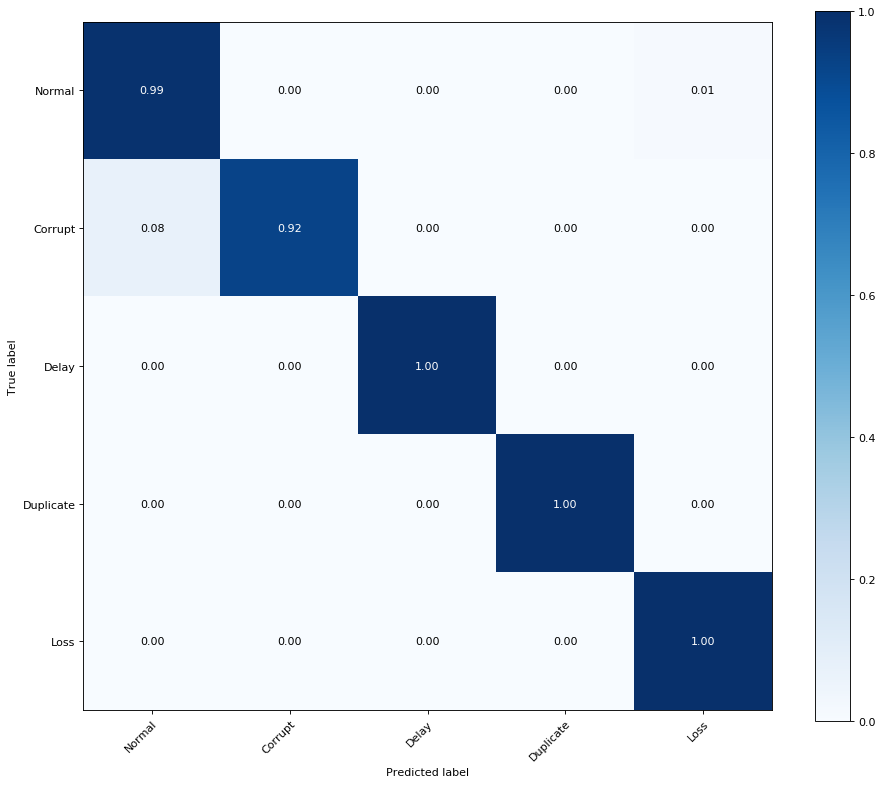

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


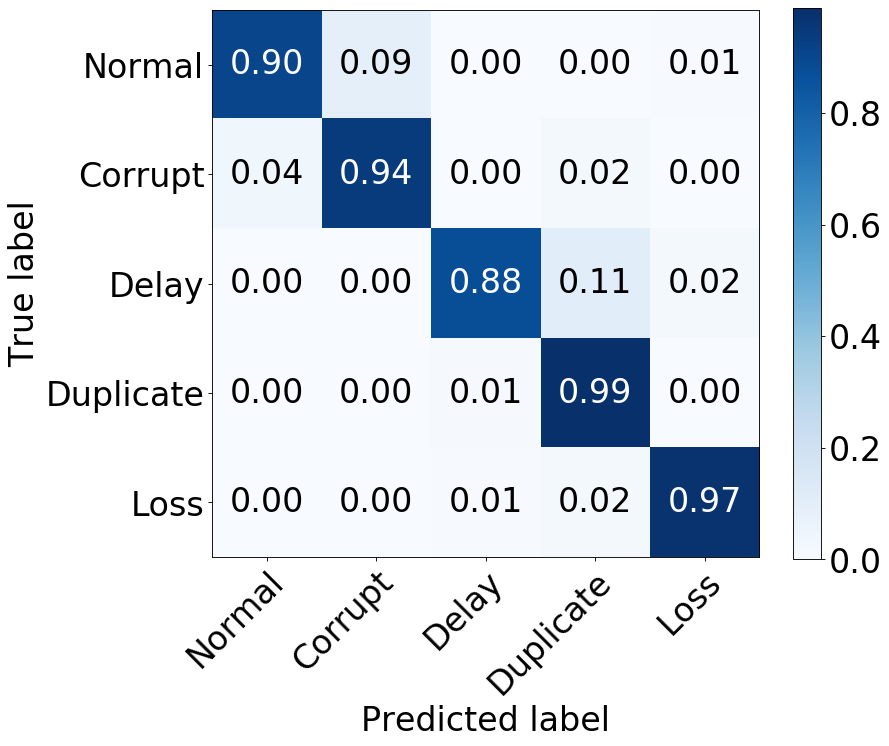

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


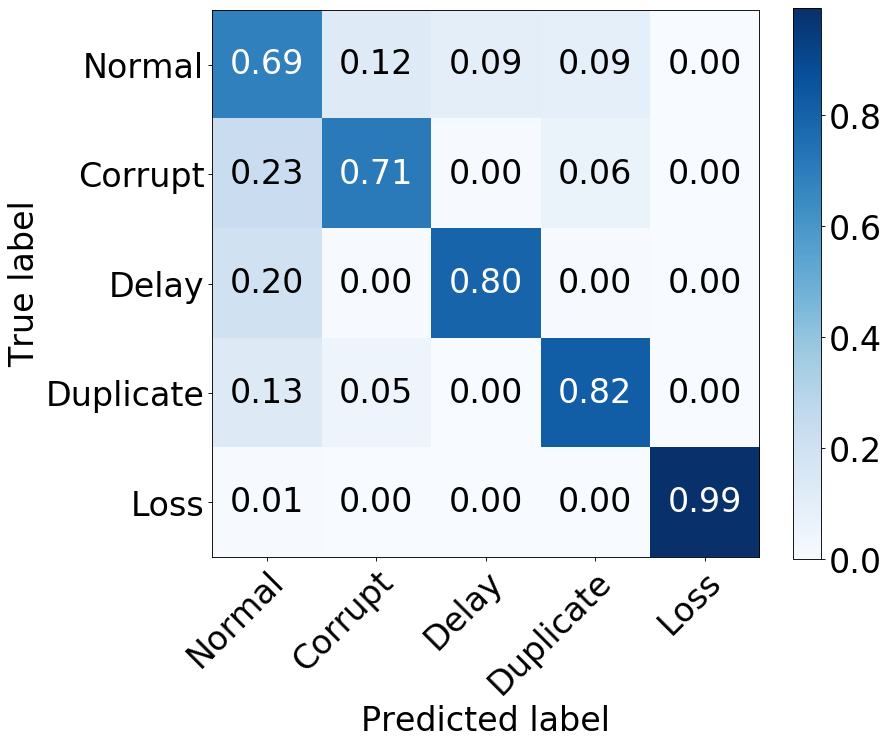

In [25]:
dtn =  DecisionTreeClassifier()
dtn.fit(dtn_train_data, dtn_train_labels)
dtn_predicted_labels = dtn.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_dtn_data_DT_CR.csv", sep='\t')
plot_confusion_matrix(dtn_test_labels, dtn_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('dtn_model_dtn_data_DT.pdf')
plt.show()
hpc_predicted_labels = dtn.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_hpc_data_DT_CR.csv", sep='\t')
emulab_predicted_labels = dtn.predict(emulab_test_data)
report = classification_report(emulab_test_labels, emulab_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_emulab_data_DT_CR.csv", sep='\t')

hpc =  DecisionTreeClassifier()
hpc.fit(hpc_train_data, hpc_train_labels)
dtn_predicted_labels = hpc.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_dtn_data_DT_CR.csv", sep='\t')
hpc_predicted_labels = hpc.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_DT_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, hpc_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_DT.pdf')
plt.show()
emulab_predicted_labels = hpc.predict(emulab_test_data)
report = classification_report(emulab_test_labels, emulab_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_emulab_data_DT_CR.csv", sep='\t')


emulab = DecisionTreeClassifier()
emulab.fit(emulab_train_data, emulab_train_labels)
dtn_predicted_labels = emulab.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_dtn_data_DT_CR.csv", sep='\t')
hpc_predicted_labels = emulab.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_hpc_data_DT_CR.csv", sep='\t')
emulab_predicted_labels = emulab.predict(emulab_test_data)
report = classification_report(emulab_test_labels, emulab_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_emulab_data_DT_CR.csv", sep='\t')
plot_confusion_matrix(emulab_test_labels, emulab_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('emulab_model_emulab_data_DT.pdf')
plt.show()


## RF :

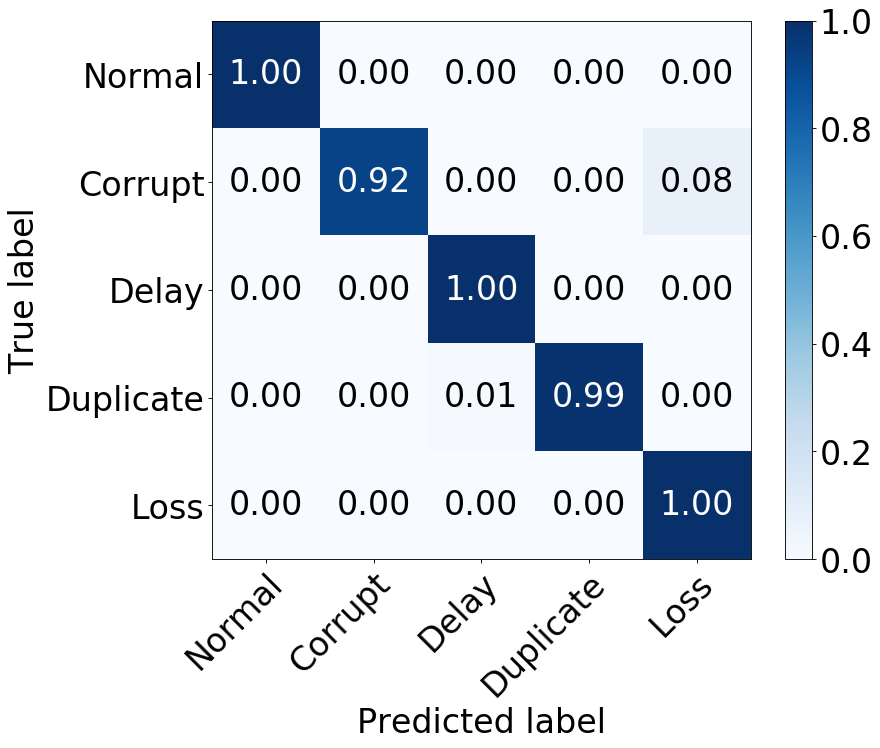

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


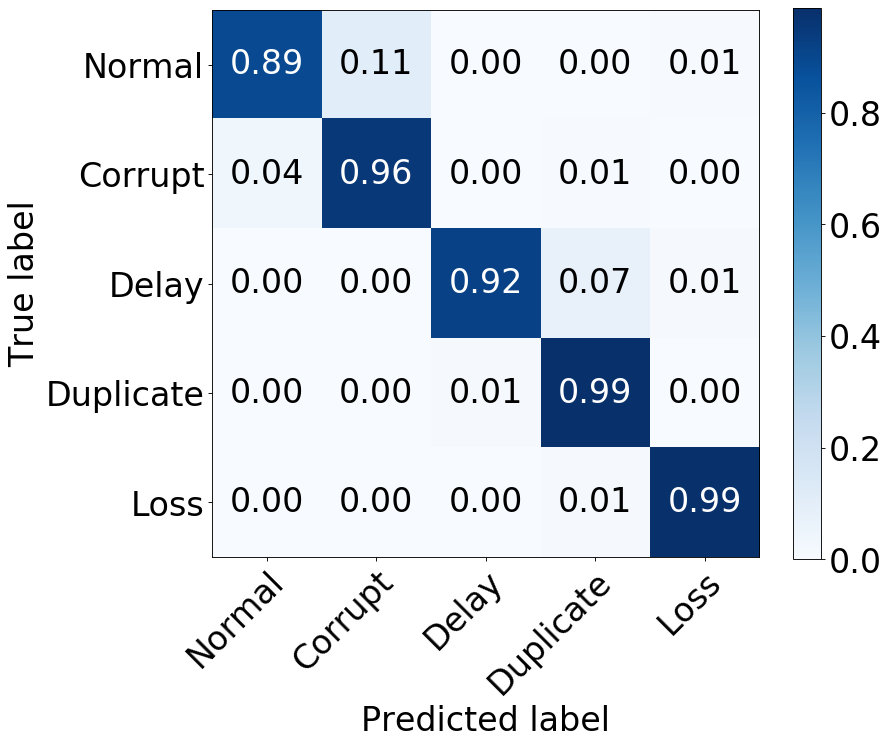

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


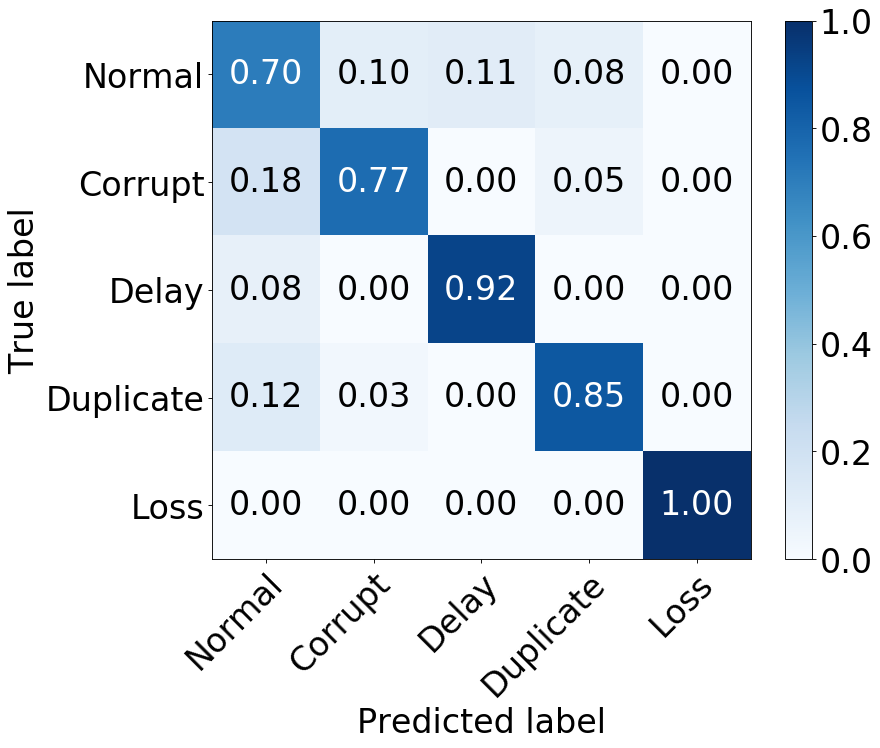

In [26]:
dtn =  RandomForestClassifier(n_estimators = 1000, random_state = 42,n_jobs = -1)
dtn.fit(dtn_train_data, dtn_train_labels)
dtn_predicted_labels = dtn.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_dtn_data_RF_CR.csv", sep='\t')
plot_confusion_matrix(dtn_test_labels, dtn_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('dtn_model_dtn_data_RF.pdf')
plt.show()
hpc_predicted_labels = dtn.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_hpc_data_RF_CR.csv", sep='\t')
emulab_predicted_labels = dtn.predict(emulab_test_data)
report = classification_report(emulab_test_labels, emulab_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_emulab_data_RF_CR.csv", sep='\t')

hpc =  RandomForestClassifier(n_estimators = 1000, random_state = 42,n_jobs = -1)
hpc.fit(hpc_train_data, hpc_train_labels)
dtn_predicted_labels = hpc.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_dtn_data_RF_CR.csv", sep='\t')
hpc_predicted_labels = hpc.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_RF_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, hpc_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_RF.pdf')
plt.show()
emulab_predicted_labels = hpc.predict(emulab_test_data)
report = classification_report(emulab_test_labels, emulab_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_emulab_data_RF_CR.csv", sep='\t')

emulab = RandomForestClassifier(n_estimators = 1000, random_state = 42,n_jobs = -1)
emulab.fit(emulab_train_data, emulab_train_labels)
dtn_predicted_labels = emulab.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_dtn_data_RF_CR.csv", sep='\t')
hpc_predicted_labels = emulab.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_hpc_data_RF_CR.csv", sep='\t')
emulab_predicted_labels = emulab.predict(emulab_test_data)
report = classification_report(emulab_test_labels, emulab_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_emulab_data_RF_CR.csv", sep='\t')
plot_confusion_matrix(emulab_test_labels, emulab_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('emulab_model_emulab_data_RF.pdf')
plt.show()


## SVM :

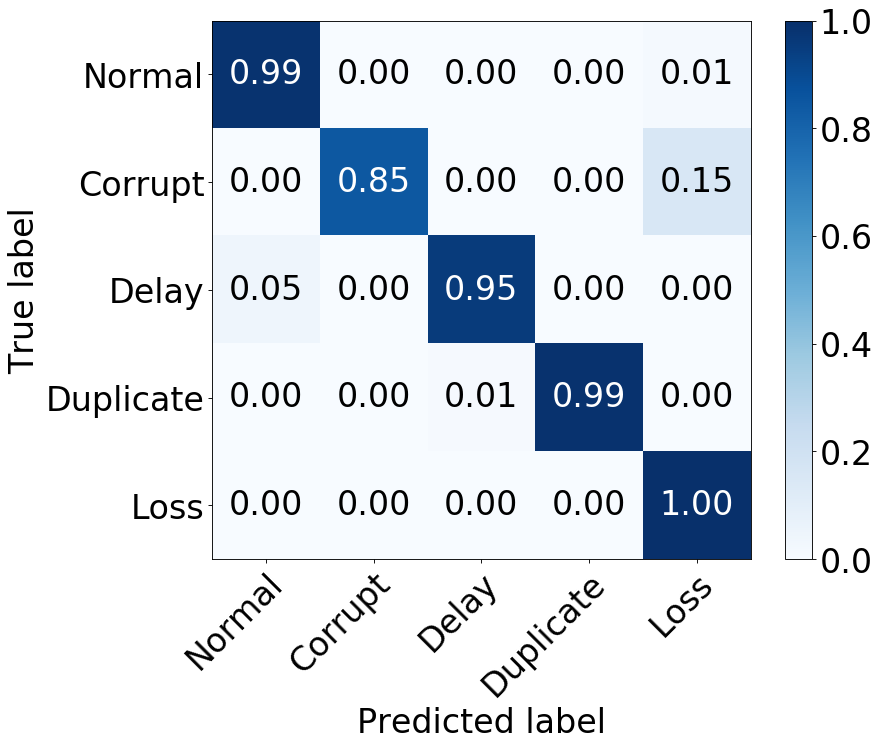

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


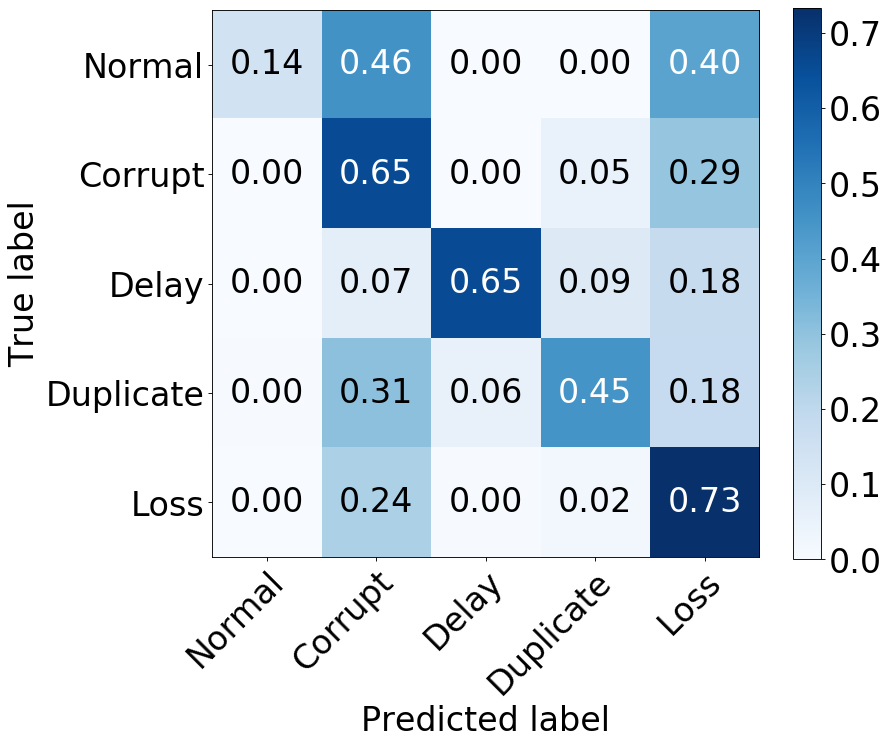

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


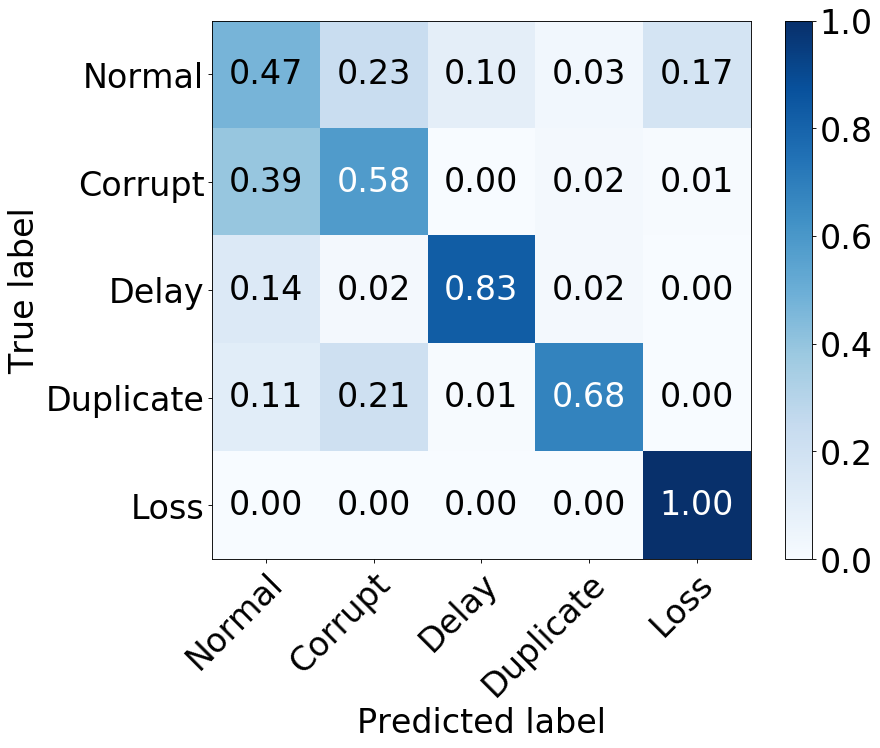

In [27]:
dtn = svm.SVC(kernel='linear', gamma ='auto', max_iter=10000)
dtn.fit(dtn_train_data, dtn_train_labels)
dtn_predicted_labels = dtn.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_dtn_data_SVM_CR.csv", sep='\t')
plot_confusion_matrix(dtn_test_labels, dtn_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('dtn_model_dtn_data_SVM.pdf')
plt.show()
hpc_predicted_labels = dtn.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_hpc_data_SVM_CR.csv", sep='\t')
emulab_predicted_labels = dtn.predict(emulab_test_data)
report = classification_report(emulab_test_labels, emulab_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_emulab_data_SVM_CR.csv", sep='\t')


hpc = svm.SVC(kernel='linear', gamma ='auto', max_iter=10000)
hpc.fit(hpc_train_data, hpc_train_labels)
dtn_predicted_labels = hpc.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_dtn_data_SVM_CR.csv", sep='\t')
hpc_predicted_labels = hpc.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_SVM_CR.csv", sep='\t')
plot_confusion_matrix(hpc_test_labels, hpc_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_SVM.pdf')
plt.show()
emulab_predicted_labels = hpc.predict(emulab_test_data)
report = classification_report(emulab_test_labels, emulab_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_emulab_data_SVM_CR.csv", sep='\t')

emulab = svm.SVC(kernel='linear', gamma ='auto', max_iter=10000)
emulab.fit(emulab_train_data, emulab_train_labels)
dtn_predicted_labels = emulab.predict(dtn_test_data)
report = classification_report(dtn_test_labels, dtn_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_dtn_data_SVM_CR.csv", sep='\t')
hpc_predicted_labels = emulab.predict(hpc_test_data)
report = classification_report(hpc_test_labels, hpc_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_hpc_data_SVM_CR.csv", sep='\t')
emulab_predicted_labels = emulab.predict(emulab_test_data)
report = classification_report(emulab_test_labels, emulab_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_emulab_data_SVM_CR.csv", sep='\t')
plot_confusion_matrix(emulab_test_labels, emulab_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('emulab_model_emulab_data_SVM.pdf')
plt.show()


## NN :

Train on 3772 samples, validate on 943 samples
Epoch 1/10
3772/3772 [==============================] - 1s 190us/step - loss: 0.6502 - accuracy: 0.7667 - val_loss: 2.8212 - val_accuracy: 0.0456
Epoch 2/10
3772/3772 [==============================] - 0s 88us/step - loss: 0.3352 - accuracy: 0.8709 - val_loss: 1.3463 - val_accuracy: 0.0467
Epoch 3/10
3772/3772 [==============================] - 0s 85us/step - loss: 0.2777 - accuracy: 0.8929 - val_loss: 1.4550 - val_accuracy: 0.0467
Epoch 4/10
3772/3772 [==============================] - 0s 103us/step - loss: 0.2672 - accuracy: 0.8924 - val_loss: 1.4123 - val_accuracy: 0.0467
Epoch 5/10
3772/3772 [==============================] - 0s 97us/step - loss: 0.2459 - accuracy: 0.9062 - val_loss: 1.7093 - val_accuracy: 0.0467


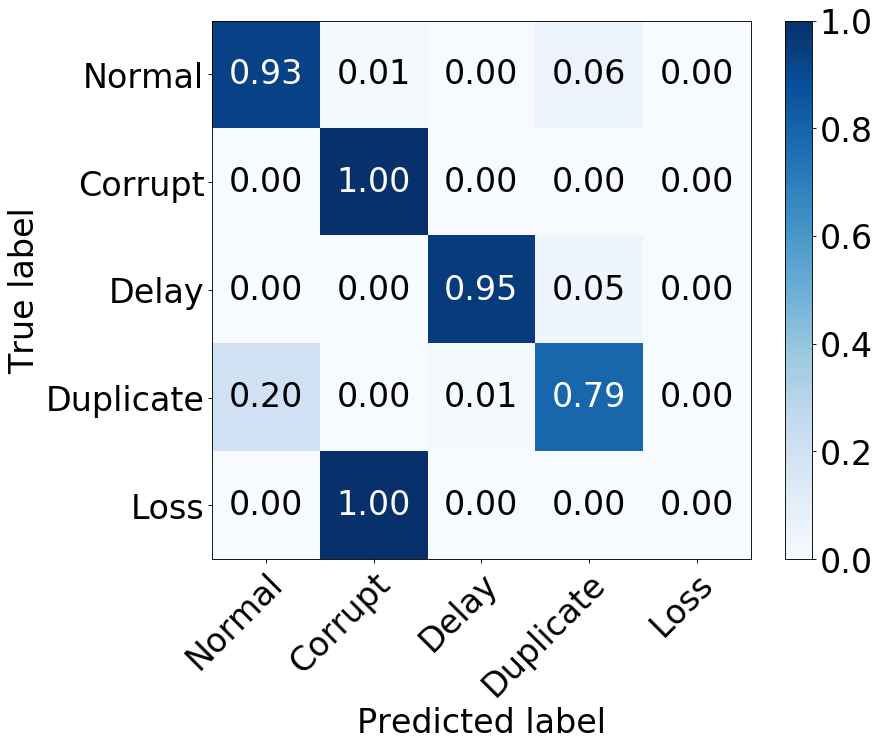

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train on 67512 samples, validate on 16878 samples
Epoch 1/10
67512/67512 [==============================] - 7s 96us/step - loss: 0.9353 - accuracy: 0.5763 - val_loss: 3.0157 - val_accuracy: 0.3002
Epoch 2/10
67512/67512 [==============================] - 6s 83us/step - loss: 0.7593 - accuracy: 0.6474 - val_loss: 2.0093 - val_accuracy: 0.3649
Epoch 3/10
67512/67512 [==============================] - 6s 85us/step - loss: 0.6792 - accuracy: 0.6843 - val_loss: 1.3606 - val_accuracy: 0.4269
Epoch 4/10
67512/67512 [==============================] - 5s 80us/step - loss: 0.6047 - accuracy: 0.7212 - val_loss: 1.6808 - val_accuracy: 0.5291
Epoch 5/10
67512/67512 [==============================] - 5s 80us/step - loss: 0.5706 - accuracy: 0.7375 - val_loss: 0.8061 - val_accuracy: 0.6886
Epoch 6/10
67512/67512 [==============================] - 5s 79us/step - loss: 0.5490 - accuracy: 0.7482 - val_loss: 0.7975 - val_accuracy: 0.6838
Epoch 7/10
67512/67512 [==============================] - 6s 84us/st

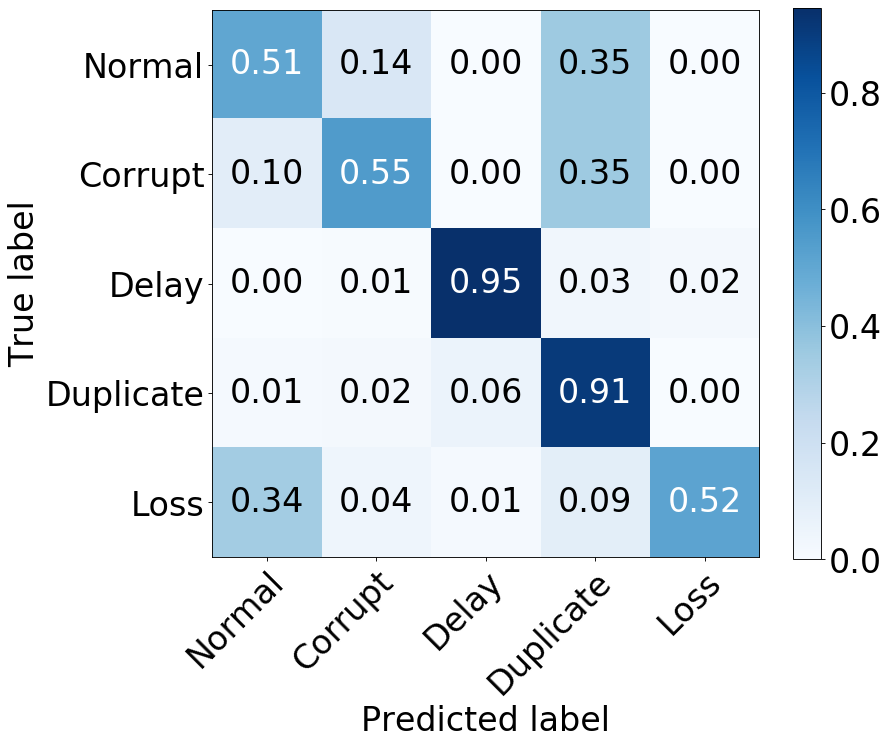

Train on 10100 samples, validate on 2525 samples
Epoch 1/10
 2016/10100 [====>.........................] - ETA: 0s - loss: 7.6269 - accuracy: 0.4410 

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


10100/10100 [==============================] - 1s 96us/step - loss: 2.2439 - accuracy: 0.5900 - val_loss: 0.3616 - val_accuracy: 0.8760
Epoch 2/10
10100/10100 [==============================] - 1s 86us/step - loss: 0.7154 - accuracy: 0.6829 - val_loss: 0.4006 - val_accuracy: 0.7976
Epoch 3/10
10100/10100 [==============================] - 1s 90us/step - loss: 0.6636 - accuracy: 0.7037 - val_loss: 0.4418 - val_accuracy: 0.7517
Epoch 4/10
10100/10100 [==============================] - 1s 81us/step - loss: 0.6374 - accuracy: 0.7083 - val_loss: 0.2778 - val_accuracy: 0.8895
Epoch 5/10
10100/10100 [==============================] - 1s 78us/step - loss: 0.6191 - accuracy: 0.7203 - val_loss: 0.2530 - val_accuracy: 0.8982
Epoch 6/10
10100/10100 [==============================] - 1s 77us/step - loss: 0.6168 - accuracy: 0.7184 - val_loss: 0.3632 - val_accuracy: 0.8174
Epoch 7/10
10100/10100 [==============================] - 1s 76us/step - loss: 0.5998 - accuracy: 0.7309 - val_loss: 0.2555 - val

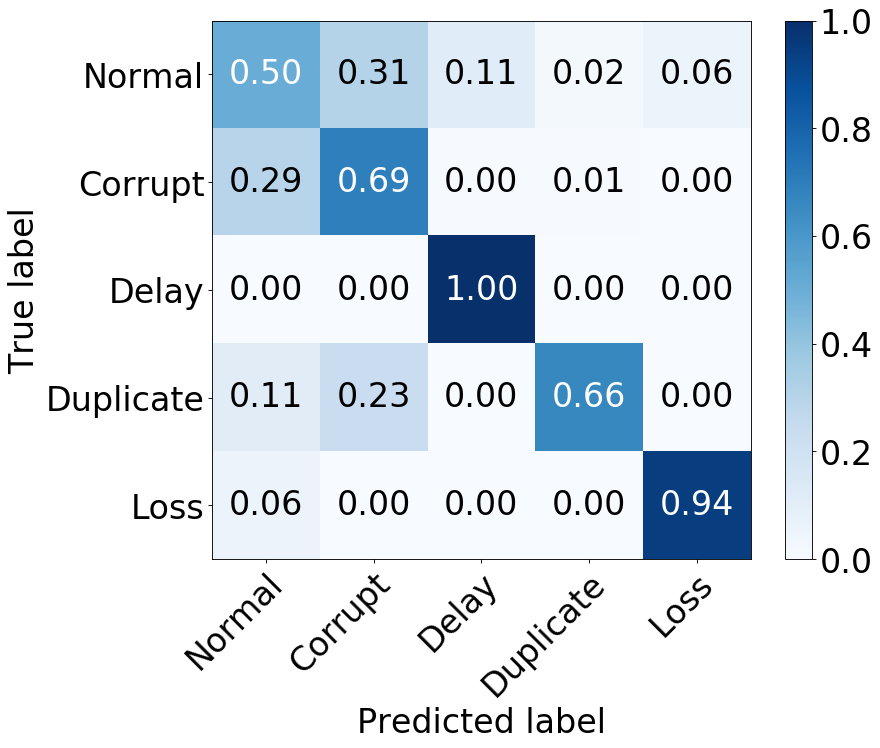

In [28]:
#create model
model = Sequential()

#get number of columns in training data
n_cols = dtn_train_data.shape[1]

#add model layers
model.add(Dense(700, activation='relu', input_dim=n_cols))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_monitor = EarlyStopping(patience=3)

dtn_train_labels = to_categorical(dtn_train_labels)
hpc_train_labels = to_categorical(hpc_train_labels)
emulab_train_labels = to_categorical(emulab_train_labels)

model.fit(dtn_train_data, dtn_train_labels, validation_split=0.2, epochs=10, callbacks=[early_stopping_monitor])
dtn_predicted_labels = model.predict(dtn_test_data)
plot_confusion_matrix(dtn_test_labels, np.argmax(dtn_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('dtn_model_dtn_data_NN.pdf')
plt.show()
report = classification_report(dtn_test_labels, np.argmax(dtn_predicted_labels, axis=1), output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_dtn_data_NN_CR.csv", sep='\t')


hpc_predicted_labels = model.predict(hpc_test_data)
report = classification_report(hpc_test_labels, np.argmax(hpc_predicted_labels, axis=1), output_dict=True )
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_hpc_data_NN_CR.csv", sep='\t')

emulab_predicted_labels = model.predict(emulab_test_data)
report = classification_report(emulab_test_labels, np.argmax(emulab_predicted_labels, axis=1), output_dict=True )
df = pd.DataFrame(report).transpose()
df.to_csv("dtn_model_emulab_data_NN_CR.csv", sep='\t')


model.fit(hpc_train_data, hpc_train_labels, validation_split=0.2, epochs=10, callbacks=[early_stopping_monitor])
dtn_predicted_labels = model.predict(dtn_test_data)
report = classification_report(dtn_test_labels, np.argmax(dtn_predicted_labels, axis=1), output_dict=True  )
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_dtn_data_NN_CR.csv", sep='\t')
hpc_predicted_labels = model.predict(hpc_test_data)
report = classification_report(hpc_test_labels,  np.argmax(hpc_predicted_labels, axis=1), output_dict=True  )
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_hpc_data_NN_CR.csv", sep='\t')

plot_confusion_matrix(hpc_test_labels, np.argmax(hpc_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('hpc_model_hpc_data_NN.pdf')
plt.show()

emulab_predicted_labels = model.predict(emulab_test_data)
report = classification_report(emulab_test_labels, np.argmax(emulab_predicted_labels, axis=1), output_dict=True )
df = pd.DataFrame(report).transpose()
df.to_csv("hpc_model_emulab_data_NN_CR.csv", sep='\t')

model.fit(emulab_train_data, emulab_train_labels, validation_split=0.2, epochs=10, callbacks=[early_stopping_monitor])
dtn_predicted_labels = model.predict(dtn_test_data)
report = classification_report(dtn_test_labels,  np.argmax(dtn_predicted_labels, axis=1), output_dict=True  )
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_dtn_data_NN_CR.csv", sep='\t')

hpc_predicted_labels = model.predict(hpc_test_data)
report = classification_report(hpc_test_labels,  np.argmax(hpc_predicted_labels, axis=1) , output_dict=True )
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_hpc_data_NN_CR.csv", sep='\t')

emulab_predicted_labels = model.predict(emulab_test_data)
report = classification_report(emulab_test_labels, np.argmax(emulab_predicted_labels, axis=1) , output_dict=True )
df = pd.DataFrame(report).transpose()
df.to_csv("emulab_model_emulab_data_NN_CR.csv", sep='\t')

plot_confusion_matrix(emulab_test_labels, np.argmax(emulab_predicted_labels, axis=1) , normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('emulab_model_emulab_data_NN.pdf')
plt.show()

# Combined Model :

## DT:

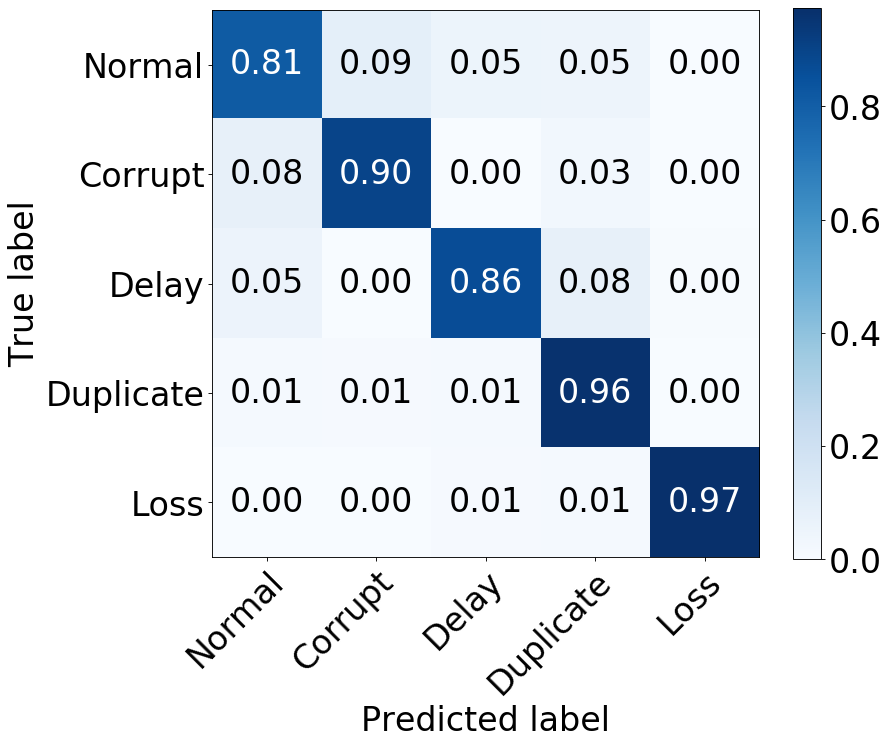

In [29]:
all_ = DecisionTreeClassifier()
all_.fit(all_train_data, all_train_labels)
all_predicted_labels = all_.predict(all_test_data)

plot_confusion_matrix(all_test_labels, all_predicted_labels, normalize=True,classes=class_names, title='')
plt.rcParams.update({'font.size': 30})
plt.savefig('all_model_all_data_DT.pdf')
plt.show()

report = classification_report(all_test_labels,all_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("combine_model_DT_CR.csv", sep='\t')

## RF :

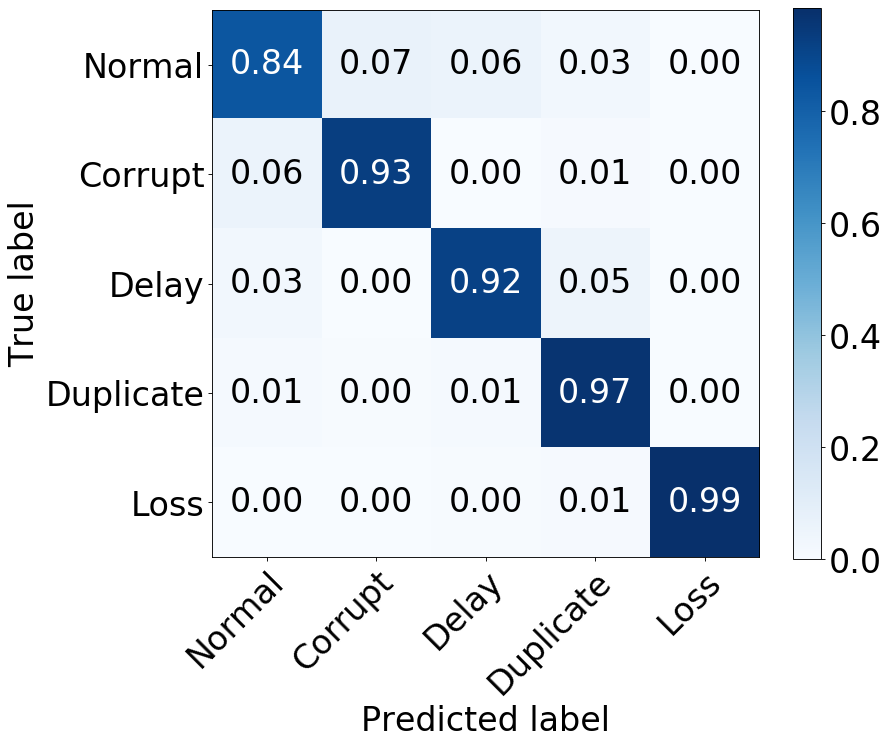

In [30]:
all_ =  RandomForestClassifier(n_estimators = 1000, random_state = 42,n_jobs = -1)
all_.fit(all_train_data, all_train_labels)
all_predicted_labels = all_.predict(all_test_data)

plot_confusion_matrix(all_test_labels, all_predicted_labels, normalize=True,classes=class_names, title='')

plt.rcParams.update({'font.size': 30})
plt.savefig('all_model_all_data_RF.pdf')
plt.show()
report = classification_report(all_test_labels,all_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("combine_model_RF_CR.csv", sep='\t')

## SVM :

/Users/pooya/conda/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


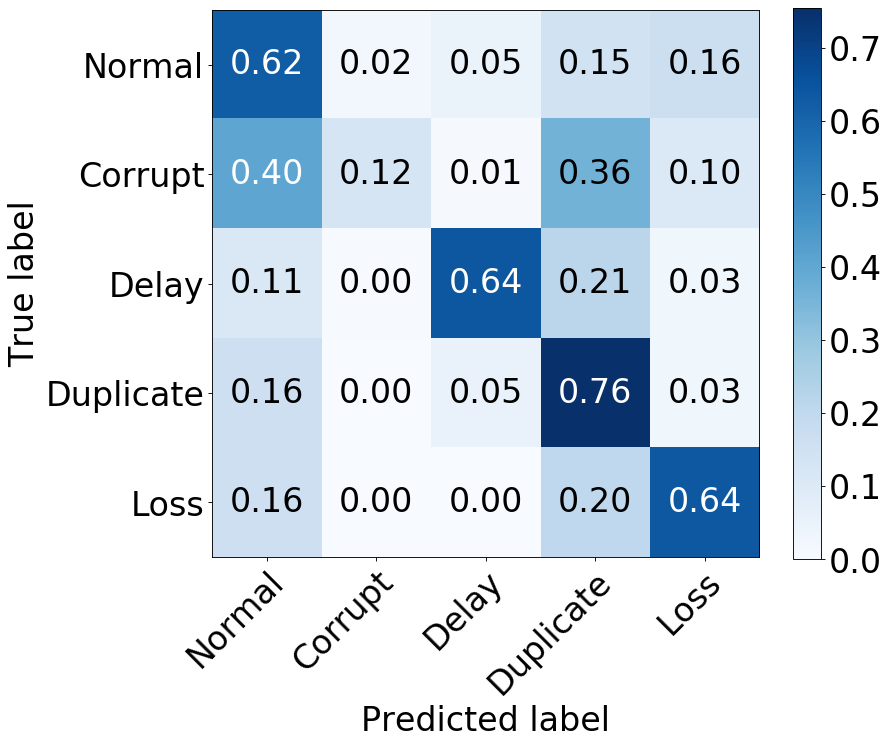

In [31]:
all_ = svm.SVC(kernel='linear', gamma ='auto', max_iter=10000)
all_.fit(all_train_data, all_train_labels)
all_predicted_labels = all_.predict(all_test_data)


plot_confusion_matrix(all_test_labels, all_predicted_labels, normalize=True,classes=class_names, title='')

plt.rcParams.update({'font.size': 30})
plt.savefig('all_model_all_data_SVM.pdf')
plt.show()
report = classification_report(all_test_labels,all_predicted_labels, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("combine_model_SVM_CR.csv", sep='\t')

## NN :

In [32]:
# model.fit(all_train_data, all_train_labels, validation_split=0.2, epochs=10, callbacks=[early_stopping_monitor])
# all_predicted_labels = all_.predict(all_test_data)


# plot_confusion_matrix(all_test_labels, all_predicted_labels, normalize=True,classes=class_names, title='')

# plt.rcParams.update({'font.size': 30})
# plt.savefig('all_model_all_data_NN.pdf')
# plt.show()

In [33]:

# class_names = ["Normal", "Corrupt", "Delay", "Duplicate", "Loss"]


# # graph = Source(tree.export_graphviz(hpc, out_file=None, class_names=class_names 
# #    , filled = True))

# # graph.render(directory='hpc')

# # graph = Source(tree.export_graphviz(dtn, out_file=None, class_names=class_names 
# #    , filled = True))

# # graph.render(directory='dtn')

# # graph = Source(tree.export_graphviz(emulab, out_file=None, class_names=class_names 
# #    , filled = True))

# # graph.render(directory='emulab')

In [34]:
# emulab_predicted_labels = emulab.predict(emulab_test_data)

# feature_imp = pd.Series(emulab.feature_importances_).sort_values(ascending=False).head(10)
# print (feature_imp)
# getKey = lambda index : data_field_labels[index] 
# x_axis =  []
# for index in feature_imp.index:
#     print(getKey(index))
#     x_axis.append(index)

# test=sns.barplot(x=x_axis, y=feature_imp, order = feature_imp.index , color = 'b')


# # Add labels to your graph
# plt.xlabel('Feature ID')
# plt.ylabel('Weight')
# plt.legend()
# plt.figure(figsize=(110, 15))

# plt.show()
# test.get_figure().savefig('dtn_important_features.pdf', bbox_inches="tight")

In [35]:

# plot_confusion_matrix(emulab_test_labels, emulab_predicted_labels, normalize=True,classes=class_names, title='')

# plt.rcParams.update({'font.size': 30})
# plt.savefig('dtn_model_dtn_data.pdf')
# plt.show()

# error_cnt = 0
# total_error_cnt = 0
# same_class_error = 0
# for i in range(len(emulab_predicted_labels)):
#     if emulab_predicted_labels[i] != emulab_test_labels[i]:
#         total_error_cnt += 1
#         # if its normal data
#         if emulab_predicted_labels[i] == 1 or emulab_test_labels[i] == 1:
#             error_cnt += 1


# print ("Total Error Count : ", total_error_cnt)
# print ("Normal Class Error Rate : ", float(error_cnt)/float(len(emulab_predicted_labels)) * 100, "%")
# print ("Total Error Rate : ", float(total_error_cnt)/float(len(emulab_predicted_labels)) * 100, "%")


# false_pos = 0
# false_neg = 0
# error_cnt = 0
# for i in range(len(emulab_predicted_labels)):
#     # if there's an error
#     if emulab_predicted_labels[i] != emulab_test_labels[i]:
#         error_cnt += 1
#         # if we failed to detect anomaly
#         if emulab_predicted_labels[i] == 1:
#             false_neg += 1
#         # detected anomaly, but it normal
#         else:
#             false_pos += 1
# print ("Total Errors", error_cnt)
# print ("False Positives ", false_pos/ float(len(emulab_predicted_labels)) * 100, "%")
# print ("False Negatives ", false_neg/ float(len(emulab_predicted_labels)) * 100, "%")


# emulab_shortened_predicted = []
# emulab_shortened_test_label = []
# for i in range(len(emulab_predicted_labels)):
#     if emulab_predicted_labels[i] == 1:
#         emulab_shortened_predicted.append(1)
#     else:
#         emulab_shortened_predicted.append(2)
#     if emulab_test_labels[i] == 1:
#         emulab_shortened_test_label.append(1)
#     else:
#         emulab_shortened_test_label.append(2)

# short_class_names = ["Normal", "Anomalous"]        

In [36]:

    
# plot_confusion_matrix(emulab_shortened_test_label, emulab_shortened_predicted, normalize=True,classes=short_class_names, 
#                       fig_size=(6,5))

# plt.rcParams.update({'font.size': 14})
# plt.savefig('emulab_model_dtn_data1.pdf')
# plt.show()

In [37]:
# dtn_predicted_labels = dtn.predict(dtn_test_data)

# feature_imp = pd.Series(dtn.feature_importances_).sort_values(ascending=False).head(10)
# print (feature_imp)
# getKey = lambda index : data_field_labels[index] 
# x_axis =  []
# for index in feature_imp.index:
#     print(getKey(index))
#     x_axis.append(index)

# test=sns.barplot(x=x_axis, y=feature_imp, order = feature_imp.index , color = 'b')


# # Add labels to your graph
# plt.xlabel('Feature ID')
# plt.ylabel('Weight')
# plt.legend()
# plt.figure(figsize=(110, 15))

# plt.show()
# test.get_figure().savefig('dtn_important_features.pdf', bbox_inches="tight")

In [38]:




# from sklearn.metrics import confusion_matrix 

# #class_names = ["Normal", "Corrupt", "Delay", "Duplicate"]
# #class_names = ["Normal", "corr_01", "corr_05", "corr_10", "delay_1_1", "delay_5_2"
# #               , "delay_10_5", "delay_25_20", "drop_01", "drop_01_2"
# #               , "drop_001", "drop_001_2", "drop_0005", "dup_01", "drop_0005_2", "dup_1"
# #              , "dup_1", "dup_2"]

# class_names = ["Normal", "Corrupt", "Delay", "Duplicate", "Loss"]

# plot_confusion_matrix(dtn_test_labels, dtn_predicted_labels, normalize=True,classes=class_names, title='')

# plt.rcParams.update({'font.size': 30})
# plt.savefig('dtn_model_dtn_data.pdf')
# plt.show()

# error_cnt = 0
# total_error_cnt = 0
# same_class_error = 0
# for i in range(len(dtn_predicted_labels)):
#     if dtn_predicted_labels[i] != dtn_test_labels[i]:
#         total_error_cnt += 1
#         # if its normal data
#         if dtn_predicted_labels[i] == 1 or dtn_test_labels[i] == 1:
#             error_cnt += 1


# print ("Total Error Count : ", total_error_cnt)
# print ("Normal Class Error Rate : ", float(error_cnt)/float(len(dtn_predicted_labels)) * 100, "%")
# print ("Total Error Rate : ", float(total_error_cnt)/float(len(dtn_predicted_labels)) * 100, "%")


# false_pos = 0
# false_neg = 0
# error_cnt = 0
# for i in range(len(dtn_predicted_labels)):
#     # if there's an error
#     if dtn_predicted_labels[i] != dtn_test_labels[i]:
#         error_cnt += 1
#         # if we failed to detect anomaly
#         if dtn_predicted_labels[i] == 1:
#             false_neg += 1
#         # detected anomaly, but it normal
#         else:
#             false_pos += 1
# print ("Total Errors", error_cnt)
# print ("False Positives ", false_pos/ float(len(dtn_predicted_labels)) * 100, "%")
# print ("False Negatives ", false_neg/ float(len(dtn_predicted_labels)) * 100, "%")


# dtn_shortened_predicted = []
# dtn_shortened_test_label = []
# for i in range(len(dtn_predicted_labels)):
#     if dtn_predicted_labels[i] == 1:
#         dtn_shortened_predicted.append(1)
#     else:
#         dtn_shortened_predicted.append(2)
#     if dtn_test_labels[i] == 1:
#         dtn_shortened_test_label.append(1)
#     else:
#         dtn_shortened_test_label.append(2)

# short_class_names = ["Normal", "Anomalous"]        
        
    

In [39]:

    
# plot_confusion_matrix(dtn_shortened_test_label, dtn_shortened_predicted, normalize=True,classes=short_class_names, 
#                       fig_size=(6,5))

# plt.savefig('dtn_model_dtn_data1.pdf')
# plt.show()

In [40]:

# hpc_predicted_labels = hpc.predict(hpc_test_data)

# feature_imp = pd.Series(hpc.feature_importances_).sort_values(ascending=False).head(10)
# print(feature_imp)

# getKey = lambda index : data_field_labels[index] 
# x_axis =  []
# for index in feature_imp.index:
#     print(getKey(index))
#     x_axis.append(index)
    
# test=sns.barplot(x=x_axis, y=feature_imp ,order = feature_imp.index, color = 'b')


# # Add labels to your graph
# plt.xlabel('Feature ID')
# plt.ylabel('Weight')
# plt.legend()
# plt.figure(figsize=(15, 15))
# test.get_figure().savefig('hpc_important_features.pdf', bbox_inches="tight")

# plt.show()

In [41]:



# from sklearn.metrics import confusion_matrix 


# class_names = ["Normal", "Corrupt", "Delay", "Duplicate", "Loss"]
# #class_names = ["Normal", "corrupt_0.1perc", "corrupt_0.5perc", "corrupt_1.0perc", "delay_1_1", "delay_5_2"
# #               , "delay_10_5", "delay_25_20", "loss_5perc", "loss_10perc"
# #               , "loss_15perc"
# #              , "dup_10perc", "dup_20perc"]



# plot_confusion_matrix(hpc_test_labels, hpc_predicted_labels, normalize=True,classes=class_names)

# plt.savefig('hpc_model_hpc_data.pdf')
# plt.show()

# error_cnt = 0
# total_error_cnt = 0
# same_class_error = 0
# for i in range(len(hpc_predicted_labels)):
#     if hpc_predicted_labels[i] != hpc_test_labels[i]:
#         total_error_cnt += 1
#         # if its normal data
#         if hpc_predicted_labels[i] == 1 or hpc_test_labels[i] == 1:
#             error_cnt += 1


# print ("Total Error Count : ", total_error_cnt)
# print ("Normal Class Error Rate : ", float(error_cnt)/float(len(hpc_predicted_labels)) * 100, "%")
# print ("Total Error Rate : ", float(total_error_cnt)/float(len(hpc_predicted_labels)) * 100, "%")


# false_pos = 0
# false_neg = 0
# error_cnt = 0
# for i in range(len(hpc_predicted_labels)):
#     # if there's an error
#     if hpc_predicted_labels[i] != hpc_test_labels[i]:
#         error_cnt += 1
#         # if we failed to detect anomaly
#         if hpc_predicted_labels[i] == 1:
#             false_neg += 1
#         # detected anomaly, but it normal
#         else:
#             false_pos += 1
# print ("Total Errors", error_cnt)
# print ("False Positives ", false_pos/ float(len(hpc_predicted_labels)) * 100, "%")
# print ("False Negatives ", false_neg/ float(len(hpc_predicted_labels)) * 100, "%")


# hpc_shortened_predicted = []
# hpc_shortened_test_label = []
# for i in range(len(hpc_predicted_labels)):
#     if hpc_predicted_labels[i] == 1:
#         hpc_shortened_predicted.append(1)
#     else:
#         hpc_shortened_predicted.append(2)
#     if hpc_test_labels[i] == 1:
#         hpc_shortened_test_label.append(1)
#     else:
#         hpc_shortened_test_label.append(2)


In [42]:

# plot_confusion_matrix(hpc_shortened_test_label, hpc_shortened_predicted, normalize=True,classes=short_class_names, 
#                        fig_size=(6,5))

# plt.rcParams.update({'font.size': 20})


# plt.savefig('hpc_model_hpc_data1.pdf')
# plt.show()

In [43]:
# hod_predicted_labels = dtn.predict(hpc_test_data)

# from sklearn.metrics import confusion_matrix 

# class_names = ["Normal", "Corrupt", "Delay", "Duplicate", "Loss"]

# plot_confusion_matrix(hpc_test_labels, hod_predicted_labels, normalize=True,classes=class_names)

# plt.savefig('dtn_model_hpc_data.pdf')
# plt.show()

# error_cnt = 0
# total_error_cnt = 0
# same_class_error = 0
# for i in range(len(hod_predicted_labels)):
#     if hod_predicted_labels[i] != hpc_test_labels[i]:
#         total_error_cnt += 1
#         # if its normal data
#         if hod_predicted_labels[i] == 1 or hpc_test_labels[i] == 1:
#             error_cnt += 1


# print ("Total Error Count : ", total_error_cnt)
# print ("Normal Class Error Rate : ", float(error_cnt)/float(len(hod_predicted_labels)) * 100, "%")
# print ("Total Error Rate : ", float(total_error_cnt)/float(len(hod_predicted_labels)) * 100, "%")


# false_pos = 0
# false_neg = 0
# error_cnt = 0
# for i in range(len(hod_predicted_labels)):
#     # if there's an error
#     if hod_predicted_labels[i] != hpc_test_labels[i]:
#         error_cnt += 1
# # if we failed to detect anomaly
# if hod_predicted_labels[i] == 1:
#     false_neg += 1
# # detected anomaly, but it normal
# else:
#     false_pos += 1
# print ("Total Errors", error_cnt)
# print ("False Positives ", false_pos/ float(len(hod_predicted_labels)) * 100, "%")
# print ("False Negatives ", false_neg/ float(len(hod_predicted_labels)) * 100, "%")


# hod_shortened_predicted = []
# hod_shortened_test_label = []
# for i in range(len(hod_predicted_labels)):
#     if hod_predicted_labels[i] == 1:
#         hod_shortened_predicted.append(1)
#     else:
#         hod_shortened_predicted.append(2)
#     if hpc_test_labels[i] == 1:
#         hod_shortened_test_label.append(1)
#     else:
#         hod_shortened_test_label.append(2)

# plot_confusion_matrix(hod_shortened_test_label, hod_shortened_predicted, normalize=True,classes=short_class_names, 
#                        fig_size=(6,5))

# plt.savefig('dtn_model_hpc_data1.pdf')
# plt.show()

In [44]:
# doh_predicted_labels = hpc.predict(dtn_test_data)

# plot_confusion_matrix(dtn_test_labels, doh_predicted_labels, normalize=True,classes=class_names)

# plt.savefig('hpc_model_dtn_data.pdf')
# plt.show()

# error_cnt = 0
# total_error_cnt = 0
# same_class_error = 0

# for i in range(len(doh_predicted_labels)):
#     if doh_predicted_labels[i] != dtn_test_labels[i]:
#         total_error_cnt += 1
#         # if its normal data
#         if doh_predicted_labels[i] == 1 or dtn_test_labels[i] == 1:
#             error_cnt += 1
            
# print ("Total Error Count : ", total_error_cnt)
# print ("Normal Class Error Rate : ", float(error_cnt)/float(len(doh_predicted_labels)) * 100, "%")
# print ("Total Error Rate : ", float(total_error_cnt)/float(len(doh_predicted_labels)) * 100, "%")

# false_pos = 0
# false_neg = 0
# error_cnt = 0

# for i in range(len(doh_predicted_labels)):
#     # if there's an error
#     if doh_predicted_labels[i] != dtn_test_labels[i]:
#         error_cnt += 1
#         # if we failed to detect anomaly
#         if doh_predicted_labels[i] == 1:
#             false_neg += 1
#         # detected anomaly, but it normal
#         else:
#             false_pos += 1
# print ("Total Errors", error_cnt)
# print ("False Positives ", false_pos/ float(len(doh_predicted_labels)) * 100, "%")
# print ("False Negatives ", false_neg/ float(len(doh_predicted_labels)) * 100, "%")


# doh_shortened_predicted = []
# doh_shortened_test_label = []
# for i in range(len(doh_predicted_labels)):
#     if doh_predicted_labels[i] == 1:
#         doh_shortened_predicted.append(1)
#     else:
#         doh_shortened_predicted.append(2)
#     if dtn_test_labels[i] == 1:
#         doh_shortened_test_label.append(1)
#     else:
#         doh_shortened_test_label.append(2)

# plot_confusion_matrix(doh_shortened_test_label, doh_shortened_predicted, normalize=True,classes=short_class_names, 
#                        fig_size=(6,5))

# plt.savefig('hpc_model_dtn_data1.pdf')
# plt.show()

In [45]:
# all_predicted_labels = all_.predict(all_test_data)

# feature_imp = pd.Series(all_.feature_importances_).sort_values(ascending=False).head(10)


# getKey = lambda index : data_field_labels[index-1] 
# x_axis =  []
# for index in feature_imp.index:
#     print(getKey(index))
#     x_axis.append(index)

# test=sns.barplot(x=x_axis, y=feature_imp, order = feature_imp.index , color = 'b')


# # Add labels to your graph
# plt.xlabel('Feature ID')
# plt.ylabel('Weight')
# plt.legend()
# plt.figure(figsize=(15, 15))

# test.get_figure().savefig('mix_model_important_features.pdf', bbox_inches="tight")
# plt.show()

In [46]:

# from sklearn.metrics import confusion_matrix 

# class_names = ["Normal", "Corrupt", "Delay", "Duplicate", "Loss"]

# plot_confusion_matrix(all_test_labels, all_predicted_labels, normalize=True,classes=class_names)
# plt.savefig('mix_model_mix_data.pdf')
# plt.show()

# error_cnt = 0
# total_error_cnt = 0
# same_class_error = 0

# for i in range(len(all_predicted_labels)):
#     if all_predicted_labels[i] != all_test_labels[i]:
#         total_error_cnt += 1
#         # if its normal data
#         if all_predicted_labels[i] == 1 or all_test_labels[i] == 1:
#             error_cnt += 1


# print ("Total Error Count : ", total_error_cnt)
# print ("Normal Class Error Rate : ", float(error_cnt)/float(len(all_predicted_labels)) * 100, "%")
# print ("Total Error Rate : ", float(total_error_cnt)/float(len(all_predicted_labels)) * 100, "%")


# false_pos = 0
# false_neg = 0
# error_cnt = 0
# for i in range(len(all_predicted_labels)):
#     # if there's an error
#     if all_predicted_labels[i] != all_test_labels[i]:
#         error_cnt += 1
#         # if we failed to detect anomaly
#         if all_predicted_labels[i] == 1:
#             false_neg += 1
#         # detected anomaly, but it normal
#         else:
#             false_pos += 1
# print ("Total Errors", error_cnt)
# print ("False Positives ", false_pos/ float(len(all_predicted_labels)) * 100, "%")
# print ("False Negatives ", false_neg/ float(len(all_predicted_labels)) * 100, "%")

# all_shortened_predicted = []
# all_shortened_test_label = []

# for i in range(len(all_predicted_labels)):
#     if all_predicted_labels[i] == 1:
#         all_shortened_predicted.append(1)
#     else:
#         all_shortened_predicted.append(2)
#     if all_test_labels[i] == 1:
#         all_shortened_test_label.append(1)
#     else:
#         all_shortened_test_label.append(2)


In [47]:

# plot_confusion_matrix(all_shortened_test_label, all_shortened_predicted, normalize=True,classes=short_class_names, 
#                      fig_size=(6,5))

# plt.savefig('mix_model_mix_data1.pdf')
# plt.show()

In [48]:

# X_resampled, y_resampled = SMOTE().fit_resample(hpc_data, hpc_anom_type_data_labels)
# hpc_train_data, hpc_test_data, hpc_train_labels, hpc_test_labels = train_test_split(X_resampled, 
#                                                                     y_resampled, random_state=seed)
# # 
# X_resampled, y_resampled = SMOTE().fit_resample(dtn_data, dtn_anom_type_data_labels)

# dtn_train_data, dtn_test_data, dtn_train_labels, dtn_test_labels = train_test_split(X_resampled, 
#                                                                     y_resampled, random_state=seed)

# X_resampled, y_resampled = SMOTE().fit_resample(all_data, all_anom_type_data_labels)
# all_train_data, all_test_data, all_train_labels, all_test_labels = train_test_split(X_resampled, 
#                                                                     y_resampled, random_state=seed)

# hpc_test_labels = to_categorical(hpc_test_labels)
# scores2 = model.evaluate(hpc_test_data, hpc_test_labels)

# print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))  

# dtn_test_labels = to_categorical(dtn_test_labels)
# scores2 = model.evaluate(dtn_test_data, dtn_test_labels)

# print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))  

# all_test_labels = to_categorical(all_test_labels)
# scores2 = model.evaluate(all_test_data, all_test_labels)

# print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))  

In [49]:

# feature_imp = pd.Series().set_value(1,2).append(pd.Series().set_value(1,4))
# # feature_imp = pd.Series(dtn.feature_importances_).sort_values(ascending=False)

# # feature_imp2 = pd.Series(hpc.feature_importances_).sort_values(ascending=False)

# # feature_imp = feature_imp.append(feature_imp2)


# test=sns.barplot(x=feature_imp.index, y=feature_imp)


# # Add labels to your graph
# plt.xlabel('Feature')
# plt.ylabel('Weight')
# plt.legend()
# plt.show()
